## The 20 Newsgroup dataset

In [2]:
# choose, for example 6 topics
categories = ['alt.atheism', 'comp.windows.x', 'rec.autos', 'rec.sport.baseball', 'sci.electronics', 'sci.space']

In [3]:
from sklearn.datasets import fetch_20newsgroups

# load the dataset
train = fetch_20newsgroups(
    subset='train', categories=categories, remove=('headers', 'footers', 'quotes'), random_state=42)

test = fetch_20newsgroups(
    subset='test', categories=categories, remove=('headers', 'footers', 'quotes'), random_state=42)

print(list(train.target_names))

['alt.atheism', 'comp.windows.x', 'rec.autos', 'rec.sport.baseball', 'sci.electronics', 'sci.space']


In [4]:
import pandas as pd
train_df = pd.DataFrame({'text': train.data, 'label': train.target})
test_df = pd.DataFrame({'text': test.data, 'label': test.target})

train_df.head()

,text,label
0,"Benedikt Rosenau writes, with great authority:...",0
1,\nI don't understand this last statement about...,2
2,I'd like to compile X11r5 on a Sony NWS-1750 r...,1
3,"\n\n\nHow do you know it's based on ignorance,...",0
4,\nmuch crap deleted\n\n\nDEAD WRONG! Last tim...,3


In [5]:
# rename labels to keys using lambda function (maps the label index to the label name)
train_df['label'] = train_df['label'].map(lambda ind: train.target_names[ind])
test_df['label'] = test_df['label'].map(lambda ind: test.target_names[ind])
train_df

,text,label
0,"Benedikt Rosenau writes, with great authority:...",alt.atheism
1,\nI don't understand this last statement about...,rec.autos
2,I'd like to compile X11r5 on a Sony NWS-1750 r...,comp.windows.x
3,"\n\n\nHow do you know it's based on ignorance,...",alt.atheism
4,\nmuch crap deleted\n\n\nDEAD WRONG! Last tim...,rec.sport.baseball
...,...,...
3443,"Hi, I'm new to this group so please bear with ...",comp.windows.x
3444,\nNo. As soon as you blit two of this icons on...,comp.windows.x
3445,"\nThat's very interesting. I wonder, are wo...",alt.atheism
3446,"\nDidn't Alicea get a hit, though? \n\nSee y'a...",rec.sport.baseball


In [6]:
# printing a row from the dataset
print(train_df.iloc[131].text)
print(train_df.iloc[131].label)



This thread seems to be arguing the validity of a religious viewpoint
according to some utilitarian principle, i.e. atheism/religion is
wrong because it causes death.  The underlying `moral' is that death
is `wrong'.  This is a rather arbitrary measure of validity.

Get some epistemology.
alt.atheism


Plan: 
- Countvectorizer + niave bayes (simple model)
- goal will be to improve it by:
    - replace countvectorizer with tf-idf vectorizer
    - stemming and lemmatization 

tf-idf vectorizer:
- term frequency * inverse document frequency
- term frequency: how often a word appears in a document
- inverse document frequency: how often a word appears in all documents in the corpus
- tf-idf is a way to normalize the word counts for each document by how common or rare they are in the entire corpus
- TF(w,d) = $\frac{number\ of\ times\ word\ w\ appears\ in\ document\ d}{total\ number\ of\ words\ in\ document\ d}$
- iDF(w) = $log(\frac{number\ of\ documents\ in\ corpus+1}{number\ of\ documents\ containing\ word\ w+1})+1$

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

X_train = train_df.text
y_train = train_df.label
X_test = test_df.text
y_test = test_df.label

# create a pipeline
pipe_text_clf = Pipeline([('vect', TfidfVectorizer()),
                            ('clf', MultinomialNB())])

pipe_text_clf

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

In [8]:
# create a parameter grid
param_grid = {'vect__max_features': [1000, 2000, 5000, 10000],
                'vect__ngram_range': [(1, 1), (1, 2)],
                'vect__stop_words': [None, 'english'],
                'vect__min_df': [1, 5, 20, 50],
                'vect__max_df': [1.0, 0.9, 0.8],
                'vect__use_idf': [True, False]}

# instantiate the grid
grid_search = GridSearchCV(pipe_text_clf, param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=1)

# fit the grid with data
grid_search.fit(X_train, y_train)

# best accuracy
grid_search.best_score_

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


/home/jake/miniconda3/envs/sportsenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
288 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jake/miniconda3/envs/sportsenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jake/miniconda3/envs/sportsenv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jake/miniconda3/envs/sportsenv/lib/python3.10/site-packages/sklearn/pipeline.py", 

0.871228919917761

In [9]:
best_estimator = grid_search.best_estimator_

# predictions on test set
y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

# accuracy
print('Accuracy on train set: ', accuracy_score(y_train, y_train_pred))
print('Accuracy on test set: ', accuracy_score(y_test, y_test_pred))

Accuracy on train set:  0.9504060324825986
Accuracy on test set:  0.8352223190932868


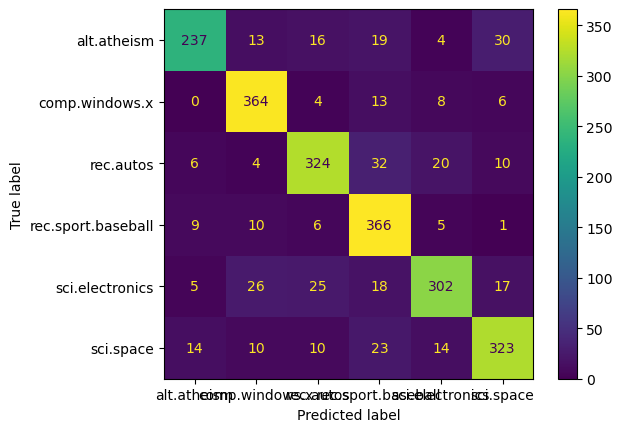

In [13]:
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()

In [17]:
# show predictions next to the input text
pd.DataFrame({'text': ['I always wanted to be an astronaut', 'Another home run for Buckley', 'I need to fix my engine', 'God is love', 'I love science', 'I love computers'],
                'prediction': best_estimator.predict(['I always wanted to be an astronaut', 'Another home run for Buckley', 'I need to fix my engine', 'God is love', 'I love science', 'I love computers'])})

,text,prediction
0,I always wanted to be an astronaut,sci.space
1,Another home run for Buckley,rec.sport.baseball
2,I need to fix my engine,rec.autos
3,God is love,alt.atheism
4,I love science,alt.atheism
5,I love computers,alt.atheism
